# Portfolio and Risk Management: HW #3
## Brian Wickman

In [35]:
from pure_eval.utils import typing_annotation_types
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import warnings

from statsmodels.iolib.summary import summary

warnings.filterwarnings("ignore")
sns.set_theme()

# help functions
import helper_funcs as helpers

# read data
FILEIN = 'data/dfa_data.xlsx'
sheet_factors = 'factors'
sheet_returns = 'portfolios (total returns)'

factors = pd.read_excel(FILEIN, sheet_name=sheet_factors).set_index('Date')
returns = pd.read_excel(FILEIN, sheet_name=sheet_returns).set_index('Date')


### Helpful Functions


In [36]:
# Summary stats function
def summary_stats(df):
    df_mean = df.mean() * 12
    df_vol = df.std() * 12**0.5
    df_sharpe = df_mean / df_vol
    df_VaR = df.quantile(0.05)

    df_stats = pd.concat([df_mean, df_vol, df_sharpe, df_VaR],
                         axis = 1,
                         keys = ['Mean', 'Volatility', 'Sharpe', 'VaR (0.05)']).round(4)
    return df_stats

# Plot cumulative returns of factors
def plot_factors_cumulative_rets(df, title):
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df['HML'], label = 'HML')
    sns.lineplot(data=df['SMB'], label = 'SMB')
    sns.lineplot(data=df['MKT'], label = 'MKT')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title(title)
    plt.legend()
    plt.show()

# CAPM with one factor (MKT, Tangency Portfolio)
def capm_regression_one_factor(df, column, factor):
    '''
    :purpose Applies regression of beta on each column of dataframe
    :return: dataframe with alpha, beta, Treynor Ratio, information ratio
    '''
    results = {}

    X = factor 
    X = sm.add_constant(X)  # Adds a constant term (alpha)
    y = df[[column]]
    model = sm.OLS(y, X).fit()

    alpha = model.params[0].round(4)
    beta = model.params[1].round(4)
    treynor_ratio = (12 * df[[column]].mean().item() / beta).round(4)
    info_ratio = np.sqrt(12) * model.params.iloc[0] / model.resid.std()

    return {'alpha': alpha, 'beta': beta, 'treynor_ratio': treynor_ratio, 'information_ratio' : info_ratio}

# CAPM with FF3 factors (MKT, Tangency Portfolio)
def capm_regression_ff3(df, column, three_factors):
    '''
    :purpose Applies regression of beta on each column of dataframe
    :return: dataframe with alpha, beta estimates
    :note: order of factors should be [MKT, SMB, HML]
    '''
    results = {}

    X = three_factors
    X = sm.add_constant(X)  # Adds a constant term (alpha)
    y = df[[column]]
    model = sm.OLS(y, X).fit()

    alpha = model.params[0].round(4)
    beta_mkt = model.params[1].round(4)
    beta_smb = model.params[2].round(4)
    beta_hml = model.params[3].round(4)

    return {'alpha': alpha, 'MKT beta': beta_mkt, 'SMB beta': beta_smb, 'HML beta': beta_hml}

# Tangency Weights
def tangency_weights(returns, cov_mat = 1):

    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*12))

    ones = np.ones(returns.columns[0:].shape)
    mu = returns.mean()*12
    scaling = 1/(np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling*(cov_inv @ mu)
    tangency_wts = pd.DataFrame(index = returns.columns[0:], data = tangent_return, columns = ['Tangent Weights'] )

    return tangency_wts

### 2. The Factors

#### (a) Univariate Performance Statistics (for HML, SMB, MKT)

1. Does each factor have a premium (positive expected excess return) in each subsample?

No, the size factor (SMB = small minus big) has a slight discount in the 1981-2001 period.

2. Does the premium to the size factor get smaller after 1980?

From 1980-2001, the size factor is a discount (-0.0009) before turning into a slight premium afer 2002 (0.0110). This implies that, based on market to book ratio, larger firms outperformed their smaller counterparts during the 80's and 90's.

3. Does the premium to the value factor get smaller during the 1990’s?

This question cannot be answered from the factor statistics, although the summary stats from 1990-1999 shows that the value factor (HML = high minus low) was a discount during this period.

4. How have the factors performed since the time of the case, (2002-present)?

Since 2002, the factors have offered a premium, suggesting that these risk premia offered excess returns during this period. Note that this does not imply market inefficiency as the excess returns were compensation for assuming excess risk.

In [37]:
# select columns
factors_subset = factors[['HML', 'SMB', 'Mkt-RF']].rename(columns = {'Mkt-RF':'MKT'})

print("Full sample:")
display(summary_stats(factors_subset))

print("1926 - 1980:")
display(summary_stats(factors_subset.loc[:'1980-12-31']))

print("1981 - 2001:")
display(summary_stats(factors_subset.loc['1981-01-01':'2001-12-31']))

#print("1990 - 1999:")
#display(summary_stats(factors_subset.loc['1990-01-01':'1999-12-31']))

print("2002 - End:")
display(summary_stats(factors_subset.loc['2002-01-01':]))

Full sample:


,Mean,Volatility,Sharpe,VaR (0.05)
HML,0.0412,0.1236,0.3337,-0.0421
SMB,0.0212,0.1100,0.1929,-0.0422
MKT,0.0822,0.1847,0.4452,-0.0793


1926 - 1980:


,Mean,Volatility,Sharpe,VaR (0.05)
HML,0.0495,0.1338,0.3697,-0.0429
SMB,0.0340,0.1146,0.2966,-0.0434
MKT,0.0811,0.2051,0.3957,-0.0840


1981 - 2001:


,Mean,Volatility,Sharpe,VaR (0.05)
HML,0.0638,0.1112,0.5736,-0.0418
SMB,-0.0009,0.1183,-0.0073,-0.0465
MKT,0.0773,0.1574,0.4908,-0.0645


2002 - End:


,Mean,Volatility,Sharpe,VaR (0.05)
HML,0.0005,0.1073,0.0050,-0.0412
SMB,0.0110,0.0889,0.1238,-0.0391
MKT,0.0895,0.1546,0.5787,-0.0787


#### (b) Factor correlation

Does the construction method succeed in keeping correlations small? Does it achieve this in each subsample?

The construction method succeeds in keeping correlations small over the full sample, although the rolling correlation plots show that the factors demonstrate correlations ranging from [-0.6,0.8] in certain 4-year periods.

Text(0.5, 1.0, 'Correlations of HML, SMB, and MKT')

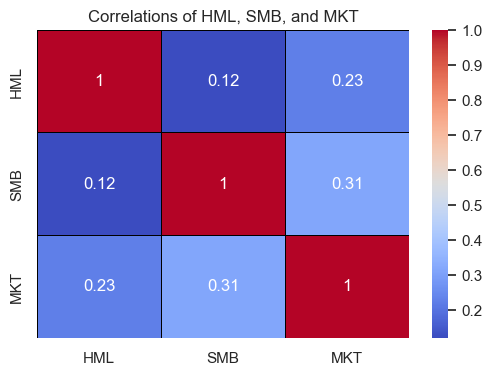

In [38]:
# Calculate the correlation matrix
corr = factors_subset.corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlations of HML, SMB, and MKT')


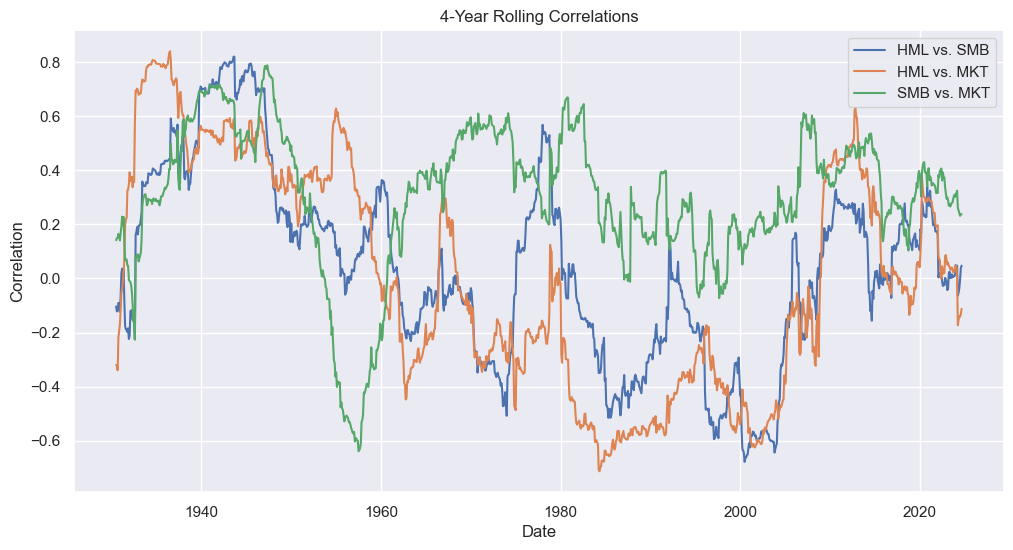

In [39]:
# Rolling correlation plots
# Calculate rolling correlations
rolling_corr_hml_smb = factors_subset['HML'].rolling(window=48).corr(factors_subset['SMB'])
rolling_corr_hml_mkt = factors_subset['HML'].rolling(window=48).corr(factors_subset['MKT'])
rolling_corr_smb_mkt = factors_subset['SMB'].rolling(window=48).corr(factors_subset['MKT'])

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_corr_hml_smb, label='HML vs. SMB')
sns.lineplot(data=rolling_corr_hml_mkt, label='HML vs. MKT')
sns.lineplot(data=rolling_corr_smb_mkt, label='SMB vs. MKT')

plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('4-Year Rolling Correlations')
plt.legend()
plt.show()

####  (c) Cumulative Returns of Factors

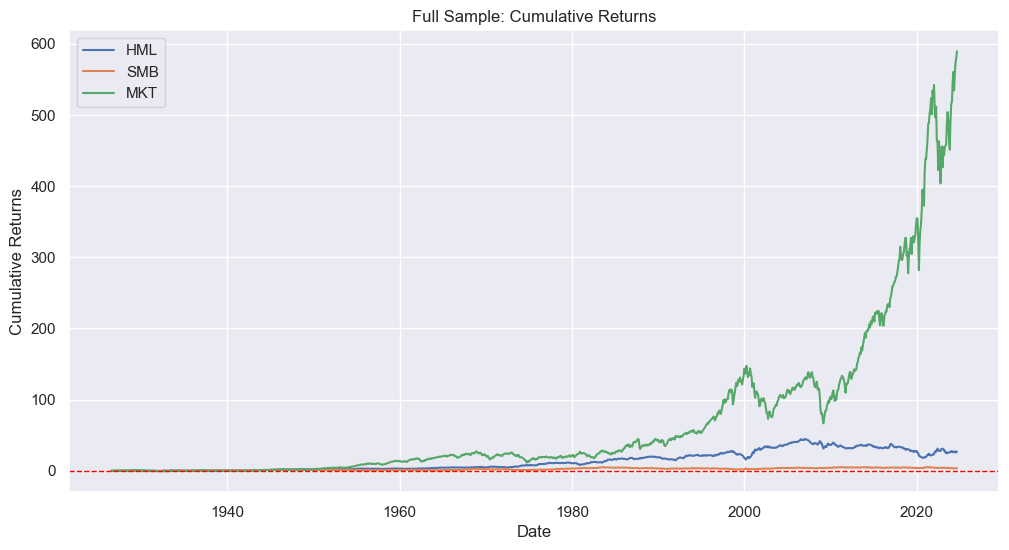

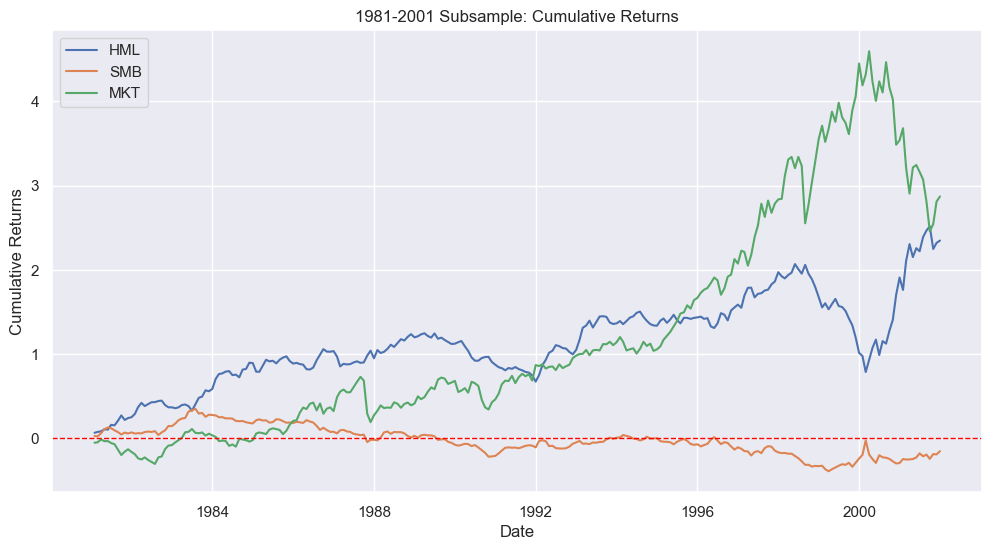

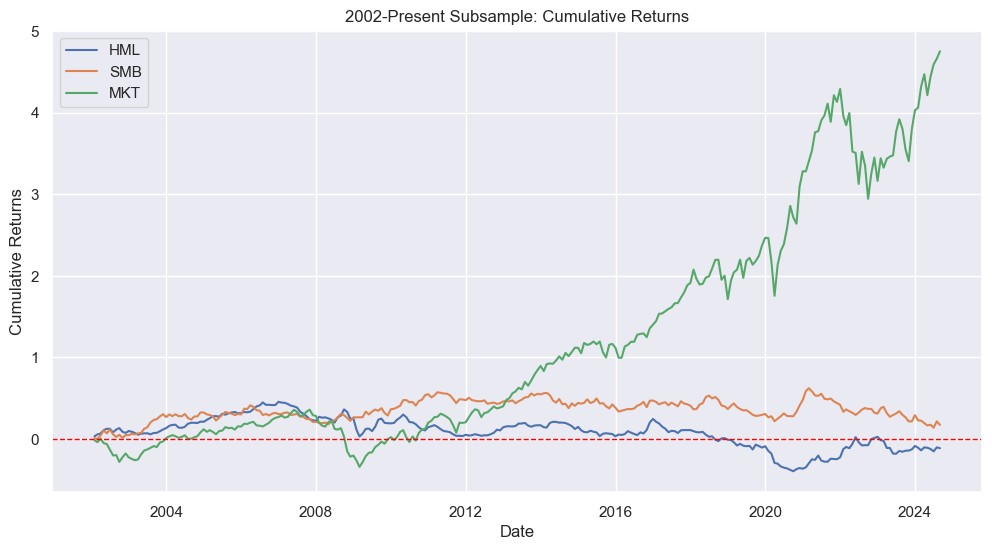

In [40]:
# Full sample
plot_factors_cumulative_rets(factors_subset.apply(lambda x: (1 + x).cumprod() - 1), 'Full Sample: Cumulative Returns')

# Subsample: 1981-2001
plot_factors_cumulative_rets(factors_subset.loc['1981-01-01':'2001-12-31'].apply(lambda x: (1 + x).cumprod() - 1), '1981-2001 Subsample: Cumulative Returns')

# Subsample: 2002-Present
plot_factors_cumulative_rets(factors_subset.loc['2002-01-01':].apply(lambda x: (1 + x).cumprod() - 1), '2002-Present Subsample: Cumulative Returns')

#### (d) Analysis

Not all three factors were 'valuable' during each period; the size factor was a discount from 1981-2001 and the value factor was a discount from 2002-Present. I would suggest that DFA continues emphasizing all factors because DFA is looking to deliver Beta, not alpha, and given the low correlations among asset, certain premias will generate excess returns depending on the period. Besides, DFA has a long-run investment horizon and does not try to time the market, so it does not align with their investment philosophy to forecast risk premia.

# 3. CAPM

#### (a) Summary Stats

1. Can the difference in mean excess returns of the portfolios be explained by differences in
 their volatilities? Or by their VaR(.05) statistics?

The difference in mean excess returns cannot be explained by differences in the portfolio volatilities or tail risk (as measured by VaR (0.05)). First, the Sharpe ratios would be near zero if the higher excess returns were a function of taking on more risk. Second, the correlation between these 25 portfolios' mean & volatility and mean & VaR are both <0.20 suggesting that another factor is driving the higher excess returns.

In [41]:
# Excess return summary stats
rf_returns = returns.apply(lambda x: x - factors['RF'])
summary_returns = summary_stats(rf_returns)

print("Mean portfolio excess returns:")
display(summary_returns)

# Relationship beween mean, vol, and tail risk
mean_vol_corr = summary_returns['Mean'].corr(summary_returns['Volatility'])
print(f"Correlation between mean and volatility: {mean_vol_corr.round(4)}.")

mean_risk_corr = summary_returns['Mean'].corr(summary_returns['VaR (0.05)'])
print(f"Correlation between mean and tail risk (VaR (0.05)): {mean_risk_corr.round(4)}.")


Mean portfolio excess returns:


,Mean,Volatility,Sharpe,VaR (0.05)
SMALL LoBM,0.0673,0.4149,0.1621,-0.1434
ME1 BM2,0.0808,0.3355,0.2409,-0.1262
ME1 BM3,0.1206,0.3179,0.3794,-0.1046
ME1 BM4,0.1370,0.2860,0.4789,-0.1022
SMALL HiBM,0.1610,0.3195,0.5040,-0.1141
ME2 BM1,0.0762,0.2759,0.2761,-0.1122
ME2 BM2,0.1123,0.2588,0.4340,-0.0978
ME2 BM3,0.1158,0.2497,0.4637,-0.0935
ME2 BM4,0.1243,0.2552,0.4870,-0.0946
ME2 BM5,0.1492,0.3003,0.4969,-0.1129


Correlation between mean and volatility: 0.2166.
Correlation between mean and tail risk (VaR (0.05)): -0.1154.


#### (b) CAPM

1. If the CAPM were true, what would we expect of the mean-absolute-error (average of alphas)?

The mean-absolute-error should theoretically be zero as asset's return should be proportional to the excess risk assumed relative to the market.

2. If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

The Treynor ratio, a measure of risk adjusted return, should be 1, the alphas should be 0, and the information ratio should be around 1 because excess returns should be due to luck (captured in the residual), not skill.

In [42]:
# Apply CAPM regression to each column
capm_results = rf_returns.apply(lambda x: pd.Series(capm_regression_one_factor(rf_returns, x.name, factor = factors_subset[['MKT']])), axis=0).T
display(capm_results.head())

# Mean-absolute-error of CAPM
mae = capm_results['alpha'].mean().round(4)
print(f"Mean-absolute-error of CAPM: {mae}.")

,alpha,beta,treynor_ratio,information_ratio
SMALL LoBM,-0.0054,1.6064,0.0419,-0.223670
ME1 BM2,-0.0028,1.3921,0.0581,-0.156078
ME1 BM3,0.0005,1.3925,0.0866,0.032591
ME1 BM4,0.0028,1.2583,0.1089,0.201020
SMALL HiBM,0.0041,1.3592,0.1185,0.249252


Mean-absolute-error of CAPM: 0.0006.


#### (c) Cross-sectional Estimation

1. If CAPM were true, what should be the R^2, intercept, and regression coefficient?

The R-squared should be 1, the intercept should be 0 and the regression coefficient should be 1. This would imply that beta perfectly explains excess returns and the regression line is y=x, where there is a one-to-one relationship between risk and excess return.

2. Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?

Yes, our empirical results of CAPM suggest that there are unaccounted for factors influencing returns other than just the equity risk premia. Thus, additional factors are required to explain more of the variations in excess returns.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


R-squared: 0.0917
Intercept: 0.0503
Regression coefficient: 0.0464


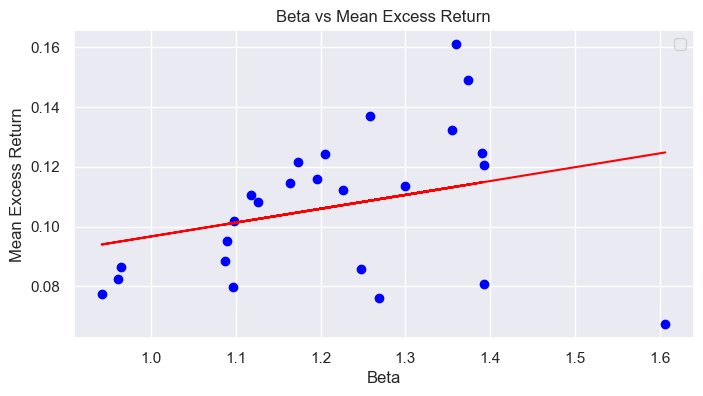

In [43]:
# Cross-sectional CAPM regression (excess returns ~ beta)
X = capm_results[['beta']]
X = sm.add_constant(X)  # Adds a constant term (alpha)
y = summary_returns[['Mean']]
model = sm.OLS(y, X).fit()

print(f"R-squared: {model.rsquared.round(4)}\nIntercept: {model.params[0].round(4)}\nRegression coefficient: {model.params[1].round(4)}")

## plot beta vs excess return
# regression predictions
predictions = model.predict(X)

# figure
plt.figure(figsize=(8, 4))
plt.scatter(X.iloc[:, 1], y, color='blue')  # First column of X without the constant
plt.plot(X.iloc[:, 1], predictions, color='red')
plt.xlabel('Beta')
plt.ylabel('Mean Excess Return')
plt.title('Beta vs Mean Excess Return')
plt.legend()



# 4. Extensions

### Mean-Variance Tangency Portfolio

<Axes: xlabel='Date'>

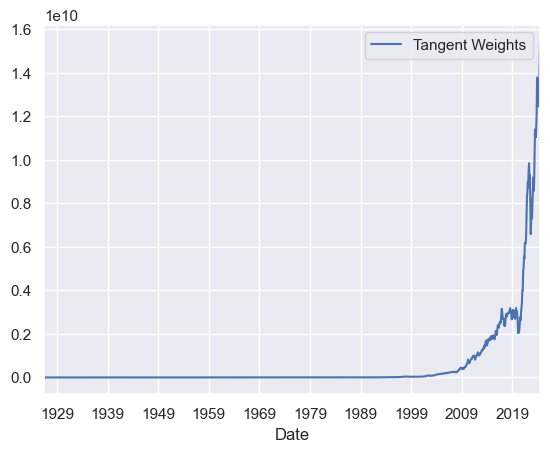

In [44]:
# Calculate in-sample tangency portfolio
wts = tangency_weights(rf_returns)
tang_portfolio_rets = rf_returns @ wts

# Plot cumulative returns
tang_portfolio_cum_return = (1 + tang_portfolio_rets).cumprod() - 1
tang_portfolio_cum_return.plot()


#### (a) MV tangency portfolio as a factor (CAPM time-series regression)

In [45]:
# Apply CAPM regression (w/ tangency portfolio) to each column
capm_tang_results = rf_returns.apply(lambda x: pd.Series(capm_regression_one_factor(rf_returns, x.name, tang_portfolio_rets)), axis=0).T
display(capm_tang_results.head())

# Mean-absolute-error of CAPM
mae = capm_tang_results['alpha'].mean().round(4)
print(f"Mean-absolute-error of CAPM: {mae}.")

,alpha,beta,treynor_ratio,information_ratio
SMALL LoBM,0.0,0.2439,0.2758,1.866746e-15
ME1 BM2,0.0,0.2931,0.2758,4.686579e-15
ME1 BM3,0.0,0.4373,0.2758,4.929396e-15
ME1 BM4,0.0,0.4967,0.2758,6.749913e-15
SMALL HiBM,0.0,0.5839,0.2758,2.958483e-15


Mean-absolute-error of CAPM: 0.0.


#### (b) MV tangency portfolio as a factor (CAPM cross-sectional regression)

The returns of the 25 style portfolios are perfectly (R-squared = 1) by the returns of the in-sample MV tangency portfolio because the tangency portfolio captures all systematic risks (of the given assets) while diversifying away all idiosyncratic ones. This is "cheating" since we optimized and tested the portfolio on the same sample.

In [46]:
# Cross-sectional CAPM regression (excess returns ~ mv tangency portfolio)
X = capm_tang_results[['beta']]
X = sm.add_constant(X)  # Adds a constant term (alpha)
y = summary_returns[['Mean']]
model = sm.OLS(y, X).fit()
print(f"R-squared: {model.rsquared.round(4)}\nIntercept: {model.params[0].round(4)}\nRegression coefficient: {model.params[1].round(4)}")

R-squared: 1.0
Intercept: 0.0
Regression coefficient: 0.2757


## Fama-French 3-Factor Model

#### (a) CAPM time-series regression with 3 factors

In [47]:
# CAPM time series
capm_ff3_ts = rf_returns.apply(lambda x: pd.Series(capm_regression_ff3(rf_returns, x.name, three_factors = factors)), axis=0).T
display(capm_ff3_ts.head())

# Mean-absolute-error of CAPM
mae_ff3 = capm_ff3_ts['alpha'].mean().round(4)
print(f"Mean-absolute-error of CAPM: {mae_ff3}.")

,alpha,MKT beta,SMB beta,HML beta
SMALL LoBM,-0.0062,1.2776,1.4632,0.3535
ME1 BM2,-0.0065,1.0767,1.5351,0.1998
ME1 BM3,-0.0008,1.0764,1.2460,0.5395
ME1 BM4,0.0012,0.9412,1.2228,0.5751
SMALL HiBM,0.0032,0.9767,1.3029,0.8967


Mean-absolute-error of CAPM: -0.0005.


#### CAPM cross-sectional regression with 3-factors

R-squared: 0.6809
Intercept: 0.2063
Regression coefficient: -0.118


Text(0.5, 1.0, 'FF3 Cross Sectional Model: Predicted vs Fitted Values')

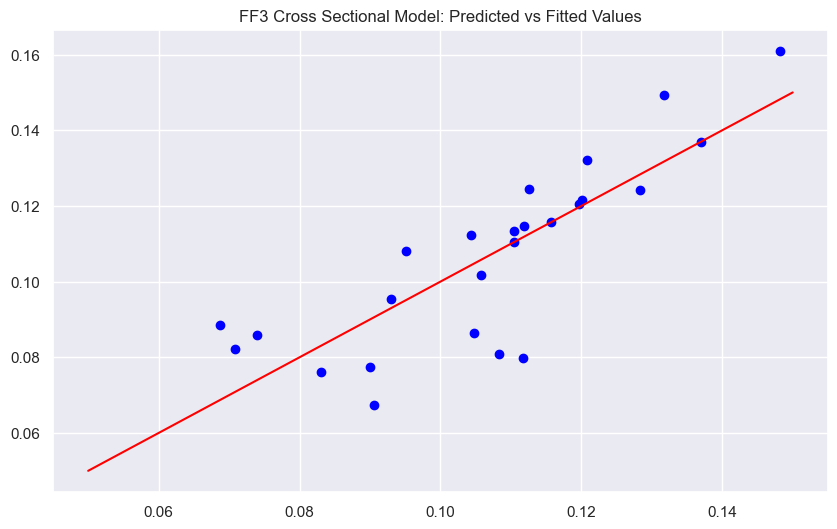

In [48]:
X = capm_ff3_ts[['MKT beta', 'SMB beta', 'HML beta']]
X = sm.add_constant(X)  # Adds a constant term (alpha)
y = summary_returns[['Mean']]
model = sm.OLS(y, X).fit()
print(f"R-squared: {model.rsquared.round(4)}\nIntercept: {model.params[0].round(4)}\nRegression coefficient: {model.params[1].round(4)}")

# FF style plot
predictions = model.predict()
actual = summary_returns['Mean']

x_values = np.arange(0.05,0.16,0.01,dtype=float)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(predictions, actual, color='blue')
plt.plot(x_values, x_values, color='red', label = "y=x")
plt.title("FF3 Cross Sectional Model: Predicted vs Fitted Values")

#### (c) Empirical Test of CAPM

1. Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating a test statistic (see homework) against the chi-squared distribution with n = 25 degrees of freedom. 

A test of checking if all the alphas have a significant t-test is stricter than testing if any of the 25 alphas are significant. Stricter in the sense that it would be harder to reject the null hypothesis that CAPM works while looking at all estimates because the single test is susceptible to noise in the alpha estimation. 

Not sure on part 2.

